In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils import utils

#### 1. Download sample data, skip this step if you've already downloaded it


In [ ]:
!wget -P data/dragon/ https://soap.cs.princeton.edu/demo/frame_bundle.npz
!wget -P data/ https://soap.cs.princeton.edu/shade_map.npy

#### 2. Load bundle from disk and investigate its contents

In [2]:
bundle_path = "data/dragon/frame_bundle.npz"
# convert to dictionary - important, by default npz load as a namespace which can have odd behaviour
bundle = dict(np.load(bundle_path, allow_pickle=True))
# remove extra dimensions
utils.de_item(bundle)

Our bundle contains four sets of data:  
1. `motion` : device motion data including rotation, gravity, and acceleration  
2. `raw_[x]` : Bayer RAW frames enumerated from `0` to `num_raw_frames - 1`, with associated metadata  
3. `rgb_[x]` : Processed Apple RGB frames enumerated from `0` to `num_rgb_frames - 1`, with associated metadata  
4. `depth_[x]` : Apple depth maps enumerated from `0` to `num_depth_frames - 1`, with associated metadata  

Lets take a closer look at this data:

In [3]:
bundle["motion"].keys()

dict_keys(['frame_count', 'timestamp', 'quaternion', 'rotation_rate', 'roll_pitch_yaw', 'acceleration', 'gravity', 'num_motion_frames'])

#### 2.1 Motion Data
The motion data `motion` contains:  
1. `frame_count` : what frame was being recorded when the associated motion data was recorded. There can be multiple motion values for the same frame as the frequency of the accelerometer/gyroscope (100Hz) is higher than the framerate we're recording at (21fps).
2. `timestamp` : absolute device time at which measurements were recorded
3. `quaternion` : device relative rotation expressed in quaternion format
4. `rotation_rate` : velocity of device rotation expressed in roll-pitch-yaw
5. `roll_pitch_yaw` : device relative rotation expressed in roll-pitch-yaw
6. `acceleration` : device relative acceleration (with gravity removed) expressed in x-y-z
7. `gravity` : acceleration due to gravity expressed in x-y-z
8. `num_motion_frames` : number of recorded measurements

As an example lets plot the device roll over time:

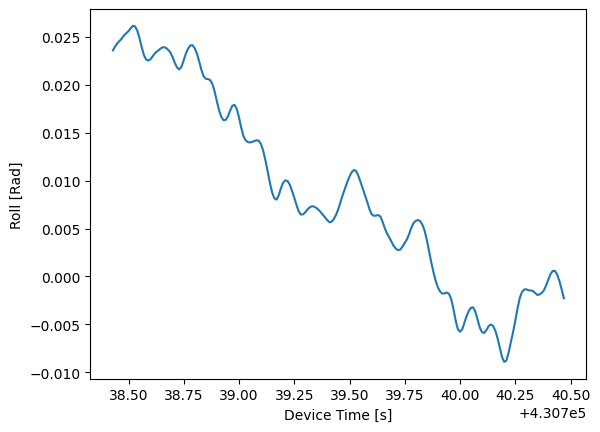

In [4]:
roll_pitch_yaw =  bundle["motion"]["roll_pitch_yaw"] # [3,N]
timestamp =  bundle["motion"]["timestamp"] # [N]
roll = roll_pitch_yaw[:,0]
pitch = roll_pitch_yaw[:,1]
yaw = roll_pitch_yaw[:,2]

plt.plot(timestamp, roll)
plt.ylabel("Roll [Rad]")
plt.xlabel("Device Time [s]")
plt.show()

#### 2.2 RAW Image Data

In [5]:
frame = 0 # change this to view other frames
raw = bundle[f"raw_{frame}"]
rgb = bundle[f"rgb_{frame}"]
depth = bundle[f"depth_{frame}"]

In [6]:
print(raw.keys())
print("height:", raw['height'], "width:", raw['width'])

dict_keys(['frame_count', 'timestamp', 'height', 'width', 'ISO', 'exposure_time', 'aperture', 'brightness', 'shutter_speed', 'black_level', 'white_level', 'raw'])
height: 3024 width: 4032


Each `raw` frame consists of:
1. `frame_count` : frame number, ranges from 0 - `num_raw_frames`
2. `timestamp` : absolute device time at which frame was recorded
3. `height, width` : frame dimensions (**WARNING**: these may not match the expected orientation of the frame, i.e. if you are recording with the phone vertical or horizontal, the `width` does not change and always refers to the long side of the capture)
4. `ISO`, `exposure_time`, `aperture` : camera ISO, exposure time (seconds), and f-stop used to capture the image
5. `brightnesss` : the estimated 'brightness' of the scene, honestly not sure what this is (pls message me if you know)
6. `shutter_speed` : inverse of `exposure_time`
7. `black_level`, `white_level`: min and max real RAW values
8. `raw`, 4032 x 3024 single channel, 14-bit mosaiced bayer CFA frame

Lets look at the RAW image data:

In [7]:
raw_img = raw["raw"]

# use simple demosaicing the fill gap values (see paper supplemental)
raw_demosaiced = utils.raw_to_rgb(torch.tensor(raw_img[None,None]))[0].permute(1,2,0)
raw_demosaiced = raw_demosaiced/raw_demosaiced.max()

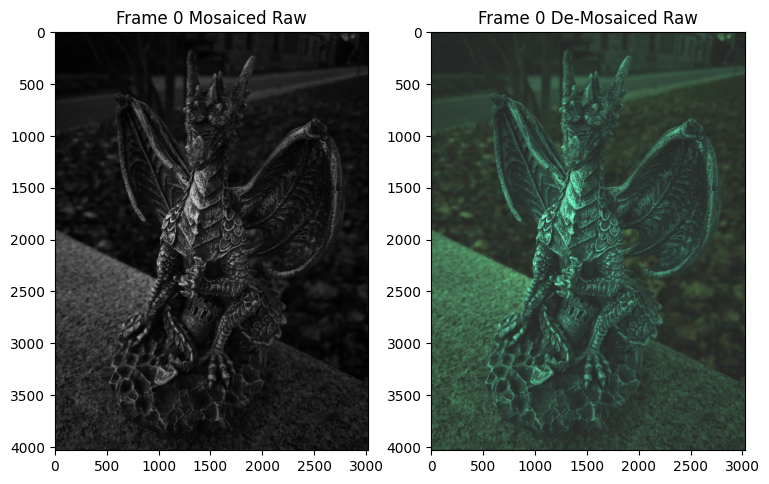

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].imshow(raw_img, cmap="gray")
axes[0].set_title(f"Frame {frame} Mosaiced Raw")
im = axes[1].imshow(raw_demosaiced)
axes[1].set_title(f"Frame {frame} De-Mosaiced Raw")

fig.subplots_adjust(right=0.7)
plt.show()

If we zoom into a small patch of the above mosaiced RAW we can see the Bayer CFA pattern:

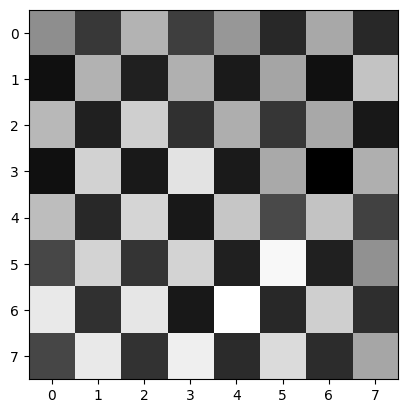

In [9]:
plt.imshow(raw_img[:8,:8], cmap="gray")
plt.show()

Applying the shade map to this data we see how it corrects for the vignetting on the edges of the scene:

In [10]:
shade_map = np.load("data/shade_map.npy")
raw_img_deshade = raw["raw"] * shade_map

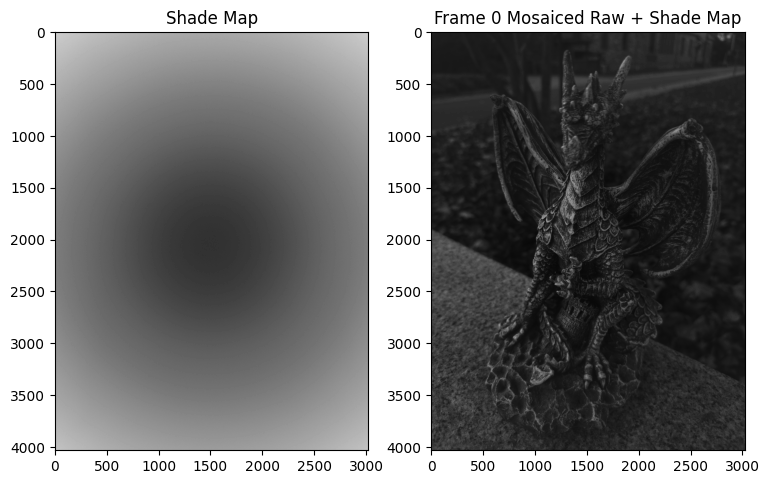

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].imshow(shade_map, cmap="gray")
axes[0].set_title(f"Shade Map")
im = axes[1].imshow(raw_img_deshade, cmap="gray")
axes[1].set_title(f"Frame {frame} Mosaiced Raw + Shade Map")

fig.subplots_adjust(right=0.7)
plt.show()

#### 2.3 Processed RGB and Depth Data

In [12]:
print(rgb.keys())
print("height:", rgb['height'], "width:", rgb['width'])

dict_keys(['frame_count', 'timestamp', 'height', 'width', 'intrinsics', 'rgb'])
height: 1440 width: 1920


Each `rgb` frame contains:
1. `frame_count`, `timestamp`, `height`, `width` : see `raw` documentation
2. `intrinsics`: 3x3 camera intrinsics, see: [documentation](https://developer.apple.com/documentation/avfoundation/avcameracalibrationdata/2881135-intrinsicmatrix)
3. `rgb`, 1920 x 1440 3 channel, 8-bit processed RGB frame

In [13]:
print(depth.keys())
print("height:", depth['height'], "width:", depth['width'])

dict_keys(['frame_count', 'timestamp', 'height', 'width', 'intrinsic_height', 'intrinsic_width', 'intrinsics', 'lens_distortion', 'lens_undistortion', 'depth_accuracy', 'depth'])
height: 240 width: 320


Each `depth` frame contains:
1. `frame_count`, `timestamp`, `height`, `width` : see `raw` documentation
2. `intrinsic_height`, `intrinsic_width`, `intrinsics` : 3x3 camera intrinsics, with associated frame height and width
3. `lens_distortion` : look-up table for radial distortion correction, see: [documentation](https://developer.apple.com/documentation/avfoundation/avcameracalibrationdata/2881129-lensdistortionlookuptable)
4. `lens_undistortion` : inverse of `lens_distortion`
5. `depth_accuracy` : [accuracy of depth measurements](https://developer.apple.com/documentation/avfoundation/avdepthdata/accuracy), depends on iPhone/iOS version. `1` -> metric depth, `0` -> relative depth
6. `depth`, 320 x 240 inverse depth map from monocular cues + LiDAR measurements

Here's a preview of what the RGB and iPhone depth data look like:

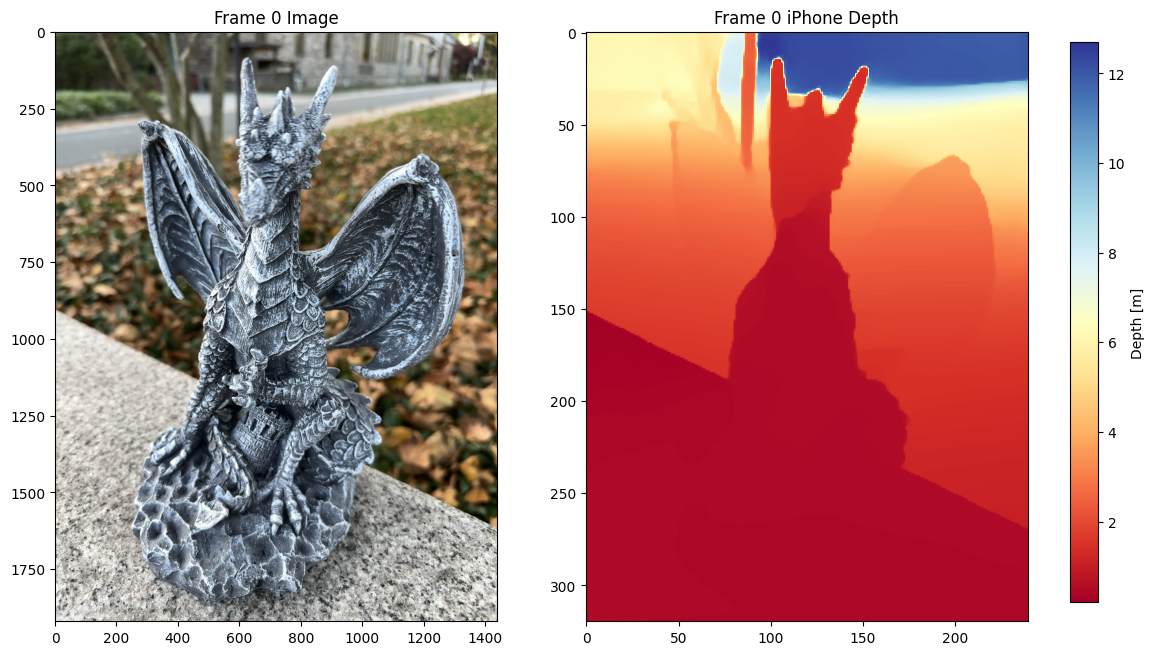


Camera Info at Frame 0: 

Timestamp: 430738.618168083 

Camera Intrinsics: 
 [[1.4021498e+03 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.4021498e+03 0.0000000e+00]
 [9.6300031e+02 7.2180786e+02 1.0000000e+00]]


In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
axes[0].imshow(rgb['rgb'])
axes[0].set_title("Frame {0} Image".format(frame))
im = axes[1].imshow(depth['depth'], cmap='RdYlBu')
axes[1].set_title("Frame {0} iPhone Depth".format(frame))

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Depth [m]')
plt.show()

print()
print("Camera Info at Frame {0}: \n".format(frame))
print("Timestamp:", rgb['timestamp'], "\n")
print("Camera Intrinsics: \n", rgb['intrinsics'])